In [1]:
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import numpy as np
from PIL import Image
from tensorflow.keras.utils import plot_model
import matplotlib.pyplot as plt

In [3]:
# To use the model later without retraining:
from tensorflow.keras.models import load_model
model = load_model('D:/PATENT/Model_testing/inflam_modified25.h5')

In [ ]:
for layer in model.layers:
    print(layer.name)

In [4]:
# Create a model for feature map extraction
feature_model = Model(inputs=model.input, outputs=model.get_layer('conv2d_2').output)

In [5]:
def extract_and_display_image(image_path, feature_model):
    img = Image.open(image_path)
    img_resized = img.resize((299, 299), Image.ANTIALIAS)
    img_array = np.array(img_resized) / 255.0
    img_array = img_array[np.newaxis, ...]

    # Display the original image
    plt.imshow(img)
    plt.title("Original Image")
    plt.axis('off')
    plt.show()

    # Get the feature maps
    feature_maps = feature_model.predict(img_array)[0]
    return feature_maps

In [6]:
def visualize_feature_maps(feature_maps, num_features=15):
    # Display the first 'num_features' feature maps
    fig, axes = plt.subplots(nrows=int(np.sqrt(num_features)), ncols=int(np.sqrt(num_features)), figsize=(10, 10))
    for i, ax in enumerate(axes.flat):
        if i < num_features:
            ax.imshow(feature_maps[:, :, i], cmap='viridis')
            ax.axis('off')
    plt.show()

In [10]:
# Improve prediction function as follows
def predict_inflammation(image_path, model):
    img = Image.open(image_path)
    img = img.resize((299, 299), Image.ANTIALIAS)  # Resize the image to match model's input
    img_array = np.array(img) / 255.0  # Rescale the image
    img_array = img_array[np.newaxis, ...]  # Add batch dimension

    # Predict the class
    prediction = model.predict(img_array)
    print(prediction)
    predicted_class = np.argmax(prediction)
    confidence = np.max(prediction)
    return predicted_class, confidence  

In [11]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from PIL import Image

def show_image(image_path):
    img = mpimg.imread(image_path)
    plt.imshow(img)
    plt.axis('off')  # Turn off axis
    plt.show()

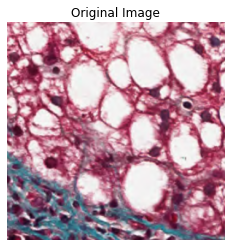

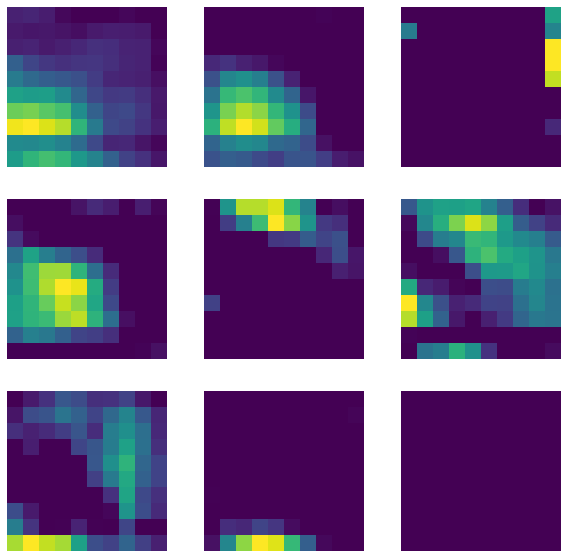

[[4.170019e-03 3.615882e-04 9.954684e-01]]
Predicted class: 2 with probability: 1.00


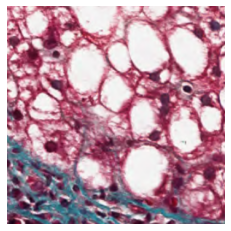

In [19]:
image_path = "D:/DATASET/CNN/inflammation/train/2/44_136_46.png"
feature_maps = extract_and_display_image(image_path, feature_model)
visualize_feature_maps(feature_maps)
predicted_class, confidence = predict_inflammation(image_path, model)
print(f'Predicted class: {predicted_class} with probability: {confidence:.2f}')
show_image(image_path)

In [ ]:
# Example use of the prediction function
image_path = "D:/DATASET/CNN/inflammation/train/2/31_184_83.png"
predicted_class, confidence = predict_inflammation(image_path, model)
print(f'Predicted class: {predicted_class} with probability: {confidence:.2f}')
show_image(image_path)

In [ ]:
def crop_and_predict(image_path, model, size=(299, 299), step_size=299):
    img = Image.open(image_path)
    width, height = img.size
    scores = []

    for top in range(0, height - size[1] + 1, step_size):
        for left in range(0, width - size[0] + 1, step_size):
            # Crop the image
            crop = img.crop((left, top, left + size[0], top + size[1]))
            # Preprocess and predict
            crop_array = np.array(crop) / 255.0
            crop_array = crop_array[np.newaxis, ...]
            prediction = model.predict(crop_array)
            scores.append(np.argmax(prediction))

    # Calculate the average score
    average_score = np.mean(scores)
    return int(round(average_score))

In [ ]:
# Use this function to get an average inflammation score from a large image
img_path = "D:/Massons Trichome staining for image analysis/20H_mt_2MON_10X_HC.jpg"
average_inflammation_score = crop_and_predict(img_path, model)
print(f'Average Inflammation Score: {average_inflammation_score}')
show_image(img_path)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model

def process_and_predict_image(model, img_path, crop_dims=(185, 93), display_crops=False):
    """
    Process an H&E stained liver biopsy image to enhance contrast, crop into patches,
    predict the NASH score for each patch, and calculate the average score.
    
    Parameters:
    - model: The trained CNN model for predicting NASH scores.
    - img_path: Path to the H&E stained liver biopsy image.
    - crop_dims: Tuple specifying the dimensions (width, height) of each crop.
    - display_crops: Boolean to determine whether to display each crop with prediction.
    
    Returns:
    - float: Average NASH score of the processed image.
    """
    # Load and process the image
    img = image.load_img(img_path)
    img_array = image.img_to_array(img)
    
    # Normalize and adjust contrast
    img_array /= 255.0  # Normalize to [0, 1]
    img_array = np.clip(img_array * 1.5, 0, 1)  # Increase contrast
    
    # Dimensions of the original image
    original_size = img_array.shape[:2]
    
    # Calculate number of crops along each dimension
    num_crops_x = original_size[1] // crop_dims[0]
    num_crops_y = original_size[0] // crop_dims[1]
    
    scores = []
    fig, axes = plt.subplots(num_crops_y, num_crops_x, figsize=(15, 10))
    ax = axes.ravel()
    
    # Crop and predict for each segment
    for i in range(num_crops_y):
        for j in range(num_crops_x):
            # Define crop boundaries
            start_y = i * crop_dims[1]
            end_y = start_y + crop_dims[1]
            start_x = j * crop_dims[0]
            end_x = start_x + crop_dims[0]
            
            # Crop the image
            crop = img_array[start_y:end_y, start_x:end_x, :]
            crop_resized = tf.image.resize(crop, (299, 299))  # Resizing to model input size
            crop_batch = np.expand_dims(crop_resized, axis=0)
            
            # Predict using the model
            prediction = model.predict(crop_batch)
            predicted_score = np.argmax(prediction)
            scores.append(predicted_score)
            
            # Display cropped images with predictions
            if display_crops:
                ax[i*num_crops_x + j].imshow(crop)
                ax[i*num_crops_x + j].set_title(f'P ({i},{j}) Score: {predicted_score}')
                ax[i*num_crops_x + j].axis('off')
    
    if display_crops:
        plt.tight_layout()
        plt.show()
    
    # Calculate average score
    average_score = np.mean(scores)
    
    return average_score

In [ ]:
# Path to the input image
img_path = "D:/scoring/Z_n-esh40x2.jpg"

# Process the image and get average score
average_nash_score = process_and_predict_image(model, img_path, display_crops=True)
print(f'Average Inflammation score for the entire image: {average_nash_score:.2f}')
show_image(img_path)